In [3]:
# Standard Imports
import pandas as pd
import numpy as np
import datetime as dt
# Viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import seaborn as sb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
import plotly.express as px



# Loading dataset

In [4]:
df = pd.read_csv("./data/Walmart_Store_sales.csv")

# Data cleaning

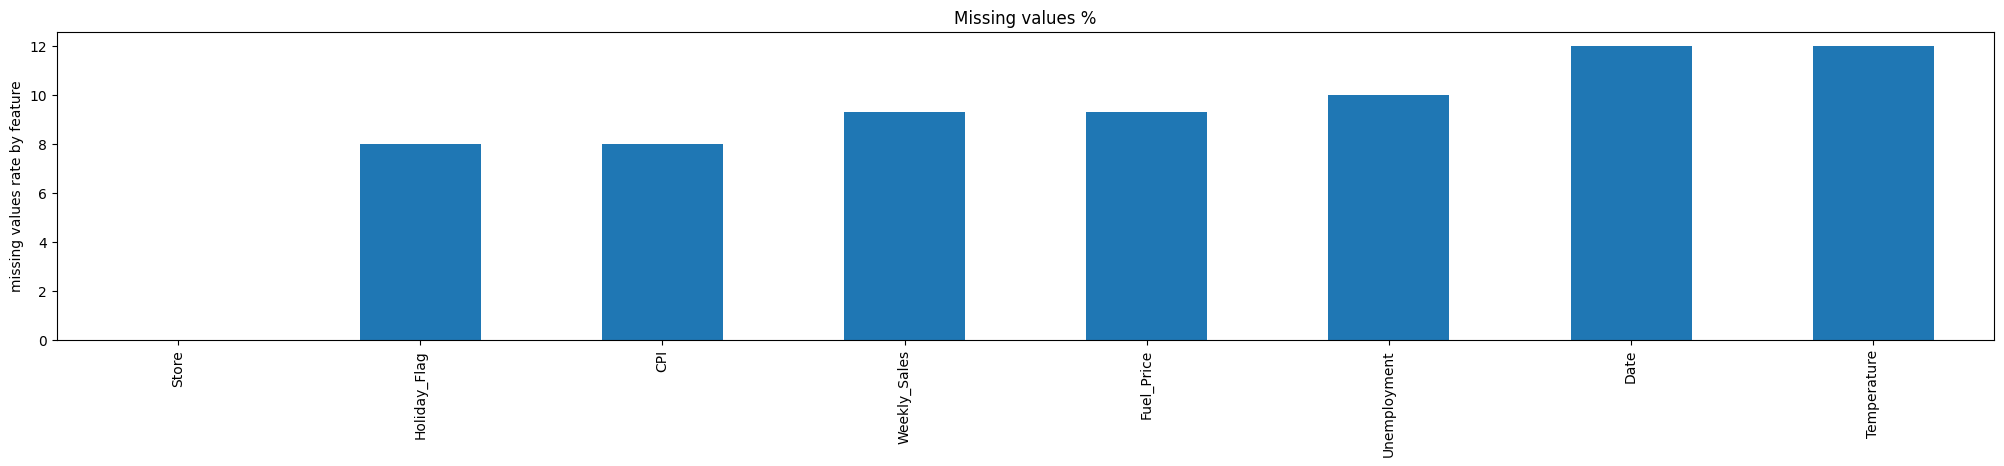

In [5]:
# Check missing values
(df.isna().mean().sort_values()*100).plot(
    kind="bar", figsize=(25, 4),
    title="Missing values %",
    ylabel="missing values rate by feature")
plt.show()

In [6]:
# Par simplicité on enlève les lignes avec des dates manquantes
df = df.dropna(subset="Weekly_Sales")
# On transforme les date en objet datetime pour pouvoir travailler avec
df["dti"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
# Création de features
df['day'] = df['dti'].dt.day
df['month'] = df['dti'].dt.month
df['quarter'] = df['dti'].dt.quarter
df['year'] = df['dti'].dt.year
df['day_of_week'] = df['dti'].dt.day_of_week


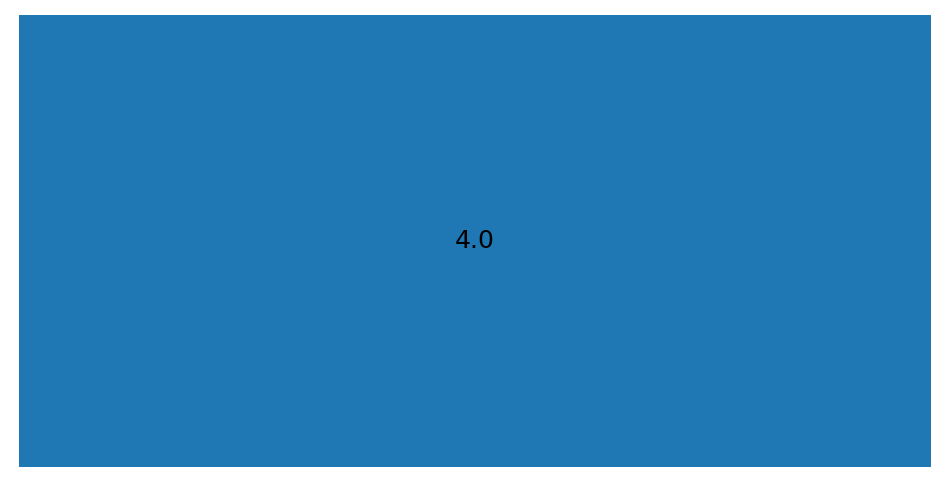

In [7]:
day_of_week = df['day_of_week'].value_counts()
plt.figure(figsize=(12, 6))
squarify.plot(sizes=day_of_week.values, label=day_of_week.index, color=sb.color_palette("tab20", len(
    day_of_week)),
    pad=0.5,
    text_kwargs={'fontsize': 18},
    )
plt.axis('off')
plt.show()


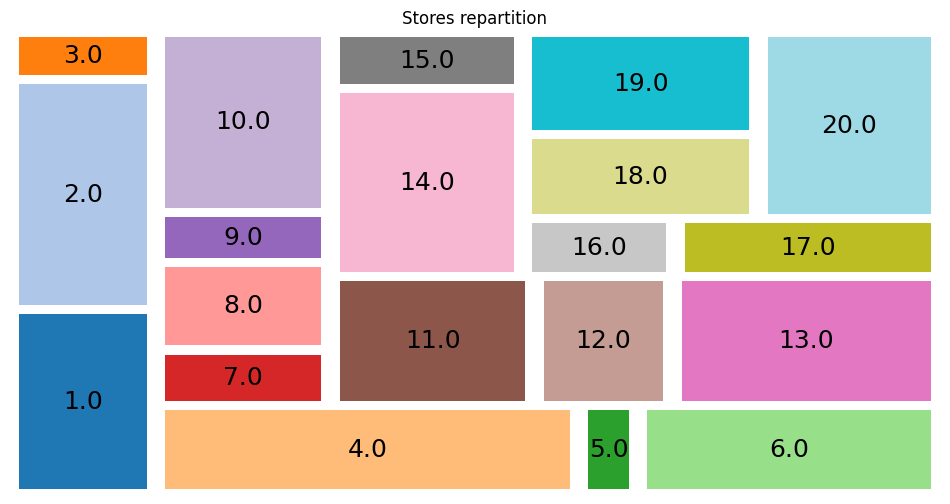

In [21]:
sales_by_store = df.groupby(by="Store").mean(numeric_only=True)["Weekly_Sales"]

plt.figure(figsize=(12, 6))
squarify.plot(sizes=sales_by_store.values, label=sales_by_store.index, color=sb.color_palette("tab20", len(
    sales_by_store)),
    pad=0.5,
    text_kwargs={'fontsize': 18})
plt.title('Stores repartition')
plt.axis('off')
plt.show()


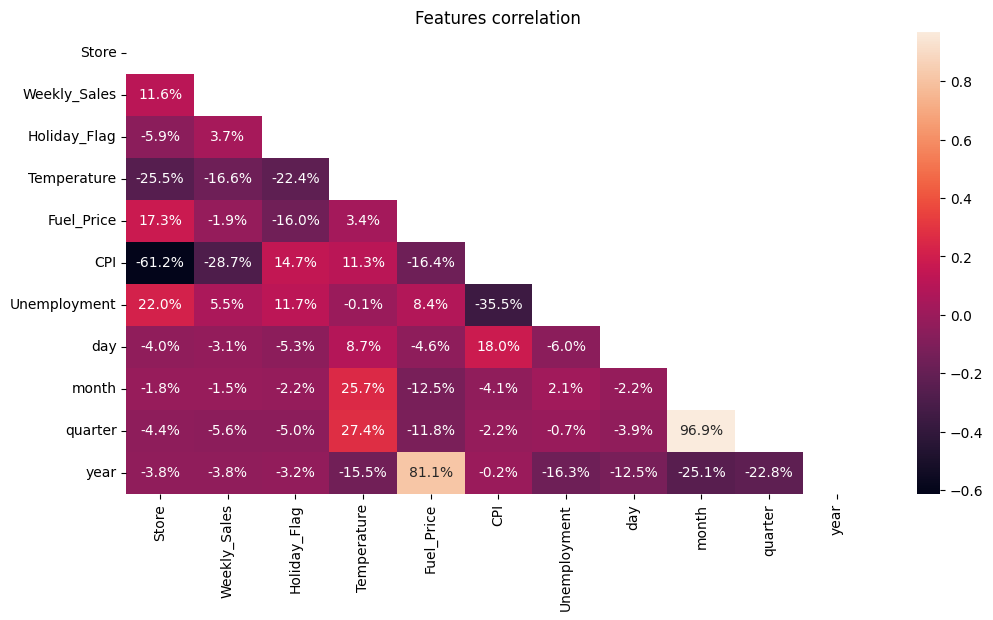

In [22]:
corr = df.iloc[:,:-1].corr(numeric_only = True)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1

plt.figure(figsize=(12,6))
plt.title('Features correlation')
sb.heatmap(corr, annot=True, mask=mask, fmt = '.1%')
plt.show()

In [10]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in df.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'day', 'month', 'quarter', 'year', 'day_of_week']
Found categorical features  ['Date', 'dti']


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=len(numeric_features), cols=len(numeric_features))

for (count_row,feature_x) in enumerate(numeric_features,1):
    for (count_col, feature_y) in enumerate(numeric_features, 1):
        fig.append_trace(go.Scatter(
            x=df[feature_x],
            y=df[feature_y],
            name=f"{feature_x} / {feature_y}",
            mode = 'markers'
            ), row=count_row, col=count_col)
fig.update_layout(height=1400, width=1400, title_text="Stacked Subplots")
fig.show()


# Modeling

In [12]:
target_name = 'Weekly_Sales'

Y = df[:][target_name]
X = df.drop(columns= [target_name])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


In [13]:
# Create pipeline for numeric features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
numeric_transformer = Pipeline(steps=[
    # missing values will be replaced by columns' median
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ["Store", "Holiday_Flag",
                        "year", "month", "day", "day_of_week"]
categorical_transformer = Pipeline(
    steps=[
        # missing values will be replaced by most frequent value
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # first column will be dropped to avoid creating correlations between features
        ('encoder', OneHotEncoder(drop='first'))
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)  # Preprocessing influenceur
X_test = preprocessor.transform(X_test)  # Preprocessing copieur

print(f'numeric_features : {numeric_features}')
print(f'categorical_features : {categorical_features}')


numeric_features : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
categorical_features : ['Store', 'Holiday_Flag', 'year', 'month', 'day', 'day_of_week']


# Linear regression Model

In [14]:
model = LinearRegression()
model.fit(X_train, Y_train)
Y_train_pred = model.predict(X_train) # Predictions on training set
Y_test_pred = model.predict(X_test) # Prédictions on test set 

# Performances evaluation

In [15]:
print("r2-score on train set : ", r2_score(Y_train, Y_train_pred))
print("Standard deviation on train set :", cross_val_score(model, X_train, Y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))

r2-score on train set :  0.9937516412309886
Standard deviation on train set : 0.059422903499747715
r2-score on test set :  0.9690490313409001


# Coefficients

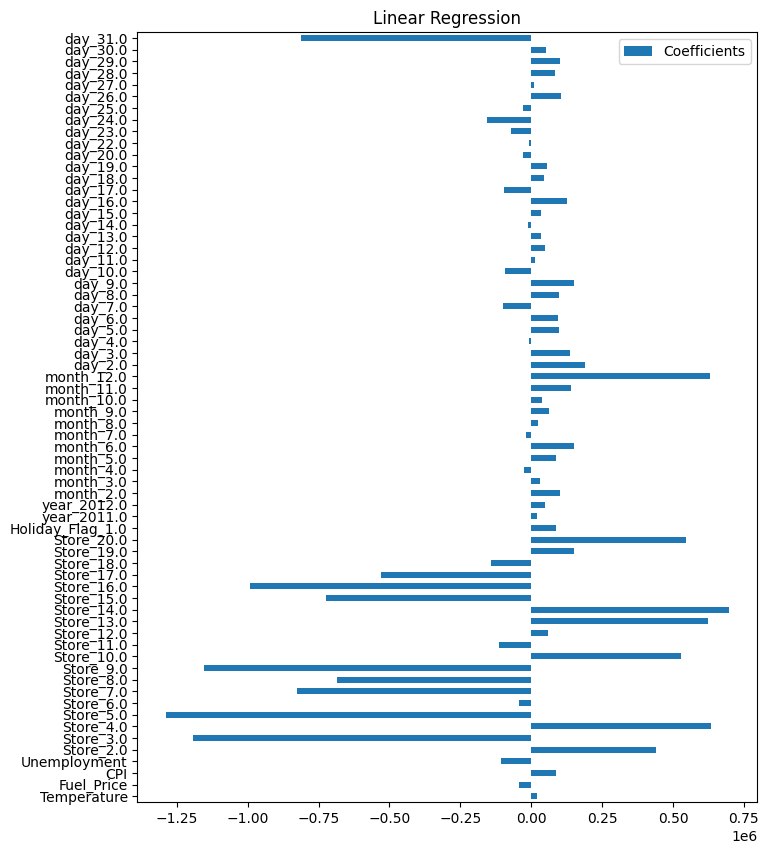

In [16]:
feature_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=feature_names
)

coefs.plot(kind='barh', figsize=(8, 10))
plt.title('Linear Regression')
plt.show()

# Ridge model

In [17]:
model = Ridge()
params = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.01}
Best validation accuracy :  0.9225675571766025


In [18]:
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, Y_train)

y_train_pred = ridge.predict(X_train)
Y_test_pred = ridge.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(ridge, X_train, Y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))

r2-score on train set :  0.9937177348323196
Standard deviation on train set : 0.0658416076966648
r2-score on test set :  0.9695002416784253


# Lasso model

In [19]:
model = Lasso(max_iter=15_000)
params = {'alpha':[0.1, 1, 10,100,500,1000]}

gridsearch = GridSearchCV(model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 1000}
Best validation accuracy :  0.9369959039971743


In [20]:
lasso = Lasso(alpha=1000)
lasso.fit(X_train, Y_train)

y_train_pred = lasso.predict(X_train)
Y_test_pred = lasso.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, y_train_pred))
print("Standard deviation on train set :", cross_val_score(lasso, X_train, Y_train, cv=10, scoring='r2').std())
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))

r2-score on train set :  0.9880130669036356
Standard deviation on train set : 0.05969792506103811
r2-score on test set :  0.9786862330065761
